In [1]:
#Numpy:  librería de Python especializada en el cálculo numérico y el análisis de datos.
import numpy as np

#Matplotlib: librería de Python especializada en la creación de gráficos en dos dimensiones.
import matplotlib.pyplot as plt

#esta libreria permite caragar un
from joblib import load as ld

#para importar los archivos de audio
from scipy.io import wavfile as wav

from scipy.signal import filtfilt, hilbert

import sys

In [2]:
#concecta con google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import pickle # This is not needed for loading .h5 models
import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/IA/Investigacion /EMG/CNN/modelo_cnn_II.h5'

# from joblib import load as ld # This is not the correct function for .h5 models

try:
  # Use load_model from tensorflow.keras.models for .h5 files
  model = load_model(model_path)
  print("Model loaded successfully!")
except Exception as e:
  print(f"Error loading the model: {e}")

Model loaded successfully!


In [51]:
ruta_archivo = '/content/drive/MyDrive/IA/Investigacion /EMG/Datos sin procesar/Bicep y tricep/archivos de audio/TRICEP/Tenis/S1_TEN_TRI.wav'
try:
  print("importando registro " + ruta_archivo)
  [Fs, Signal] = wav.read(ruta_archivo)
except:
  print("Error al importar el registro")
  sys.exit()

importando registro /content/drive/MyDrive/IA/Investigacion /EMG/Datos sin procesar/Bicep y tricep/archivos de audio/TRICEP/Tenis/S1_TEN_TRI.wav


In [7]:
pip install antropy

In [52]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
from antropy import hjorth_params

# Parámetros de ventana
window_size_samples = 500
step_size_samples = 50  # 90% de superposición

hjorth_features = []

# Extracción de características por ventana
for start_sample in range(0, len(Signal) - window_size_samples + 1, step_size_samples):
    end_sample = start_sample + window_size_samples
    segment = Signal[start_sample:end_sample]

    if len(segment) == 0:
        continue

    # Señal analítica mediante transformada de Hilbert
    analytic_signal = hilbert(segment)
    analytic_real = np.real(analytic_signal)

    # Calcular parámetros de Hjorth (actividad, movilidad y complejidad)
    activity = np.var(analytic_real)
    mobility, complexity = hjorth_params(analytic_real)

    # Guardar características
    hjorth_features.append([activity, mobility, complexity])

# Convertir a array
hjorth_features = np.array(hjorth_features)

# Normalización min-max por columna (evita división por cero)
min_vals = np.min(hjorth_features, axis=0)
max_vals = np.max(hjorth_features, axis=0)
range_vals = max_vals - min_vals
epsilon = 1e-8
hjorth_features_norm = (hjorth_features - min_vals) / (range_vals + epsilon)

# DataFrame con nombres descriptivos
feature_names = ['activity', 'mobility', 'complexity']
hjorth_features_df = pd.DataFrame(hjorth_features_norm, columns=feature_names)

# Predicciones del modelo
predictions = model.predict(hjorth_features_df.values)

# Si el modelo tiene una sola salida (por ejemplo, sigmoide)
predictions = predictions.flatten()  # pasa de (n,1) → (n,)

# Crear DataFrame de salida con predicciones
result_df = hjorth_features_df.copy()
result_df['prediction'] = predictions

print(result_df.head())


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   activity  mobility  complexity  prediction
0  0.000222  0.306661    0.288484    0.000005
1  0.000211  0.298489    0.303812    0.000005
2  0.000207  0.309303    0.296116    0.000005
3  0.000198  0.362495    0.284695    0.000005
4  0.000232  0.332127    0.311359    0.000005


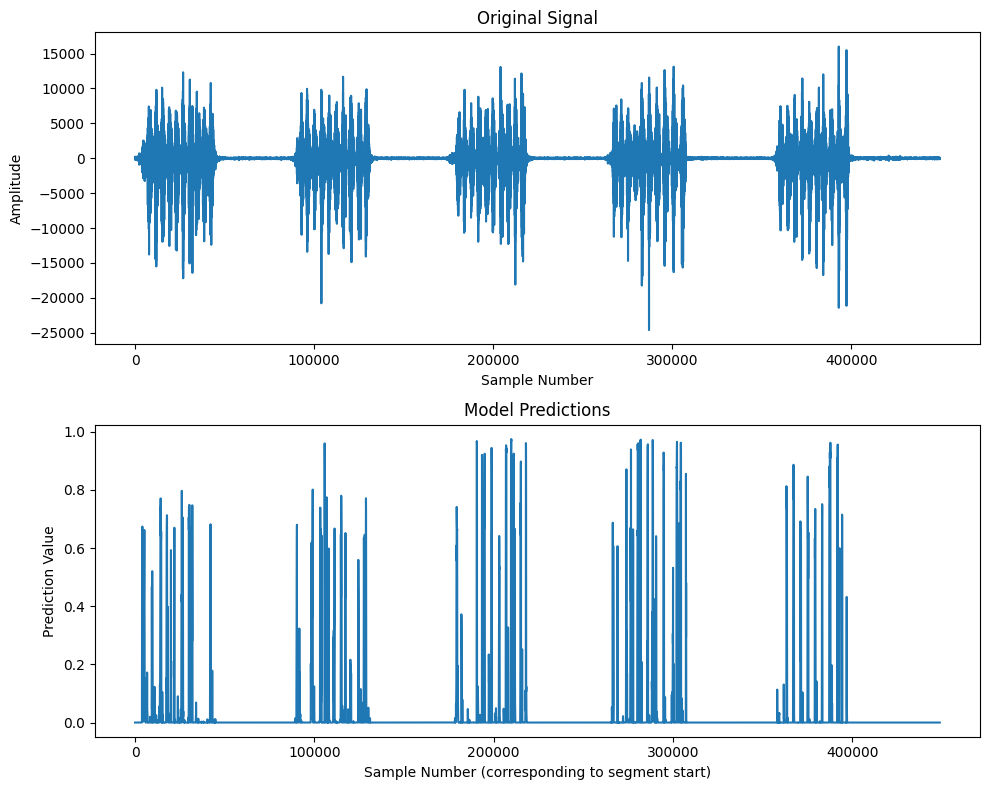

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Plot the predictions
# We need to create a time axis or index for the predictions
# Assuming each prediction corresponds to the start of a segment
prediction_indices = np.arange(len(predictions)) * step_size_samples

axes[1].plot(prediction_indices, predictions)
axes[1].set_title('Model Predictions')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Prediction Value')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

In [54]:
from scipy.ndimage import binary_closing, binary_dilation

def prob_smooth_and_threshold(probs, window_size, thr=0.5):
    """
    Suavizado de probabilidades con media móvil y umbral.
    probs: 1D numpy array de probabilidades [0..1]
    window_size: ventana para la media móvil (>=1)
    thr: umbral final para pasar a etiqueta binaria
    devuelve: etiquetas 0/1
    """
    kernel = np.ones(window_size) / window_size
    # convolución válida con padding reflect
    padded = np.pad(probs, (window_size//2,), mode='reflect')
    smoothed = np.convolve(padded, kernel, mode='valid')
    return (smoothed >= thr).astype(int)

In [58]:
import matplotlib.pyplot as plt

withprob = prob_smooth_and_threshold(predictions, window_size=250, thr=0.01)
withprob_indices = np.arange(len(withprob)) * step_size_samples


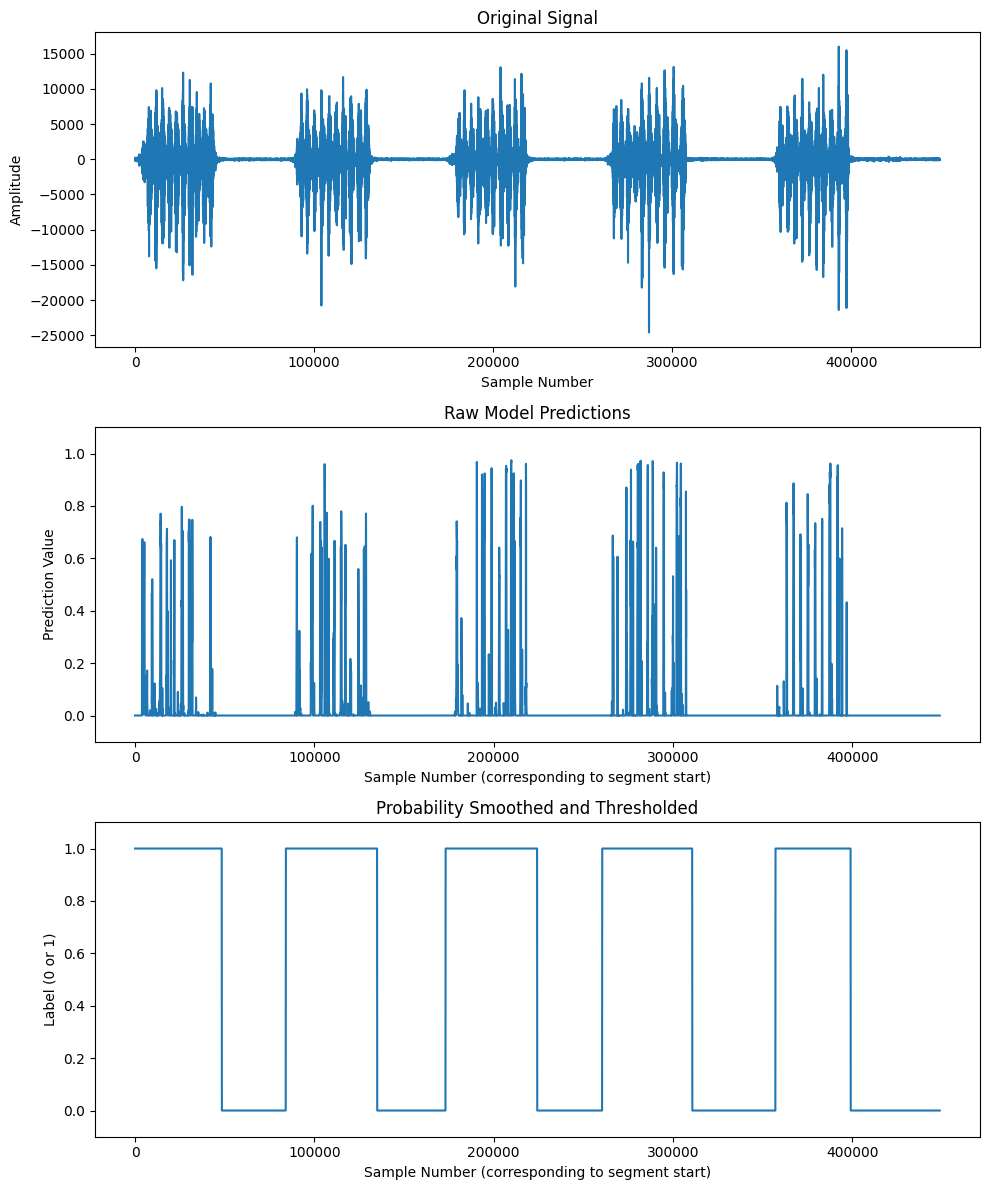

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with three subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False) # sharex=False as signal and predictions/withprob might have different x-axes if not careful

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Create a time axis or index for the predictions
prediction_indices = np.arange(len(predictions)) * step_size_samples # Assuming each element corresponds to a segment start

# Plot the raw predictions
axes[1].plot(prediction_indices, predictions)
axes[1].set_title('Raw Model Predictions')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Prediction Value')
axes[1].set_ylim([-0.1, 1.1]) # Set y-limits for clarity

# Create a time axis or index specifically for withprob
# Its length might be different due to convolution mode='valid'
withprob_indices = np.arange(len(withprob)) * step_size_samples # Assuming each element still corresponds to a segment start

# Plot withprob
axes[2].plot(withprob_indices, withprob)
axes[2].set_title('Probability Smoothed and Thresholded')
axes[2].set_xlabel('Sample Number (corresponding to segment start)')
axes[2].set_ylabel('Label (0 or 1)')
axes[2].set_ylim([-0.1, 1.1]) # Set y-limits for clarity


# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

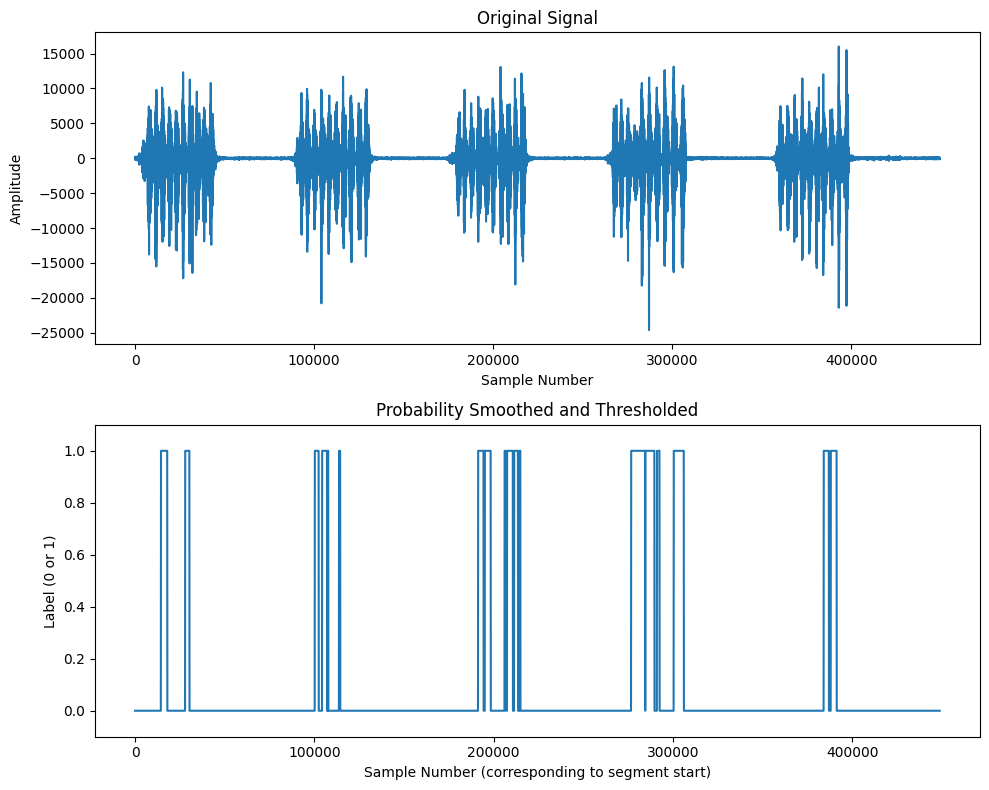

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False) # sharex=False as signal and withprob might have different x-axes if not careful

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Create a time axis or index specifically for withprob
# Its length might be different due to convolution mode='valid'
withprob_indices = np.arange(len(withprob)) * step_size_samples # Assuming each element still corresponds to a segment start

# Plot withprob
axes[1].plot(withprob_indices, withprob)
axes[1].set_title('Probability Smoothed and Thresholded')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Label (0 or 1)')
axes[1].set_ylim([-0.1, 1.1]) # Set y-limits for clarity


# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()